## Import Libraries and Raw Data

In [1]:
import pandas as pd
# Enable copy-on-write optimizations to save on memory and avoid making copies of data until written to
# The line below is to stop seeing the "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
pd.options.mode.copy_on_write = True
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
import time

# Load the raw dataset
df_raw = pd.read_csv('mgs_dataset.csv')

# Display the first few rows of the raw dataframe to inspect its structure and data types
df_raw.head()

author/last_played  author/num_games_owned  author/num_reviews  \
0          1701413897                     181                  13   
1          1721780706                     203                  17   
2          1721793868                       0                  27   
3          1721744655                       0                  59   
4          1721806317                     162                  97   

   author/playtime_at_review  author/playtime_forever  \
0                        882                      882   
1                        771                      771   
2                       1559                     1935   
3                        635                      635   
4                        247                      727   

   author/playtime_last_two_weeks     author/steamid  comment_count  \
0                               0  76561198087178952              0   
1                             771  76561198798779983              0   
2                            1177  76561198169484181              0   
3                             635  76561198069601045              0   
4                             650  76561198155945496              0   

   hidden_in_steam_china language  ...  \
0                   True  english  ...   
1                   True  english  ...   
2                   True   french  ...   
3                   True  english  ...   
4                   True  english  ...   

                                              review  steam_china_location  \
0        It's a decent port, but it could be better.                   NaN   
1  The best Quentin Tarantino film that I don't w...                   NaN   
2  Champion olympique des Olympiades esquimaux in...                   NaN   
3  Undoubtedly one of the most influential video ...                   NaN   
4                                           ta bueno                   NaN   

  steam_purchase  timestamp_created  timestamp_updated  voted_up  votes_funny  \
0           True         1721789799         1721789799      True            0   
1          False         1721781822         1721781822      True            0   
2           True         1721769431         1721769431      True            0   
3           True         1721744808         1721745044      True            0   
4           True         1721734612         1721734612      True            0   

   votes_up  weighted_vote_score  written_during_early_access  
0         0                  0.0                        False  
1         0                  0.0                        False  
2         0                  0.0                        False  
3         0                  0.0                        False  
4         0                  0.0                        False  

[5 rows x 22 columns]

## Data Wrangling

In [2]:
# Convert UNIX timestamps to datetime format for better readability
df_raw['timestamp_created'] = pd.to_datetime(df_raw['timestamp_created'], unit='s')
df_raw['timestamp_updated'] = pd.to_datetime(df_raw['timestamp_updated'], unit='s')

# Remove duplicate reviews based on 'author/steamid' and 'review' columns to ensure unique entries
df_raw.drop_duplicates(subset=['author/steamid', 'review'], inplace=True)

# Select only the necessary columns for analysis
df = df_raw[['author/steamid', 'author/playtime_at_review', 
             'timestamp_created', 'language', 'voted_up', 'review']]

# Rename columns for better readability and understanding
df.rename(columns={
    'author/steamid': 'steamid',
    'author/playtime_at_review': 'playtime_at_review',
    'timestamp_created': 'review_date',
    'voted_up' : 'recommendation'
}, inplace=True)

# Convert boolean values in 'recommendation' to string labels for clarity
df['recommendation'] = df['recommendation'].replace({True: 'recommended', False: 'not recommended'})

# Fill missing values in the 'review' column with empty strings
df['review'] = df['review'].fillna('')

# Save the cleaned dataset to a new CSV file for future use
df.to_csv('mgs_dataset_cleaned.csv', index=False)

# Display the first few rows of the cleaned dataframe to verify the changes
df.head()

steamid  playtime_at_review         review_date language  \
0  76561198087178952                 882 2024-07-24 02:56:39  english   
1  76561198798779983                 771 2024-07-24 00:43:42  english   
2  76561198169484181                1559 2024-07-23 21:17:11   french   
3  76561198069601045                 635 2024-07-23 14:26:48  english   
4  76561198155945496                 247 2024-07-23 11:36:52  english   

  recommendation                                             review  
0    recommended        It's a decent port, but it could be better.  
1    recommended  The best Quentin Tarantino film that I don't w...  
2    recommended  Champion olympique des Olympiades esquimaux in...  
3    recommended  Undoubtedly one of the most influential video ...  
4    recommended                                           ta bueno

# Quick EDA

### Recommendations Count

In [3]:
recommendation_counts = df.recommendation.value_counts()
recommendation_percentages = df.recommendation.value_counts(normalize=True) * 100

# Combine the counts and percentages into a single DataFrame
recommendation_summary = pd.DataFrame({
    'Count': recommendation_counts,
    'Percentage (%)': recommendation_percentages
})

print(recommendation_summary)

                 Count  Percentage (%)
recommendation                        
recommended       1329       73.833333
not recommended    471       26.166667


The dataset revealed 1,329 recommended reviews and 471 not recommended reviews. This means that 73% of users have given a positive recommendation, resulting in a "Mostly Positive" rating on Steam.

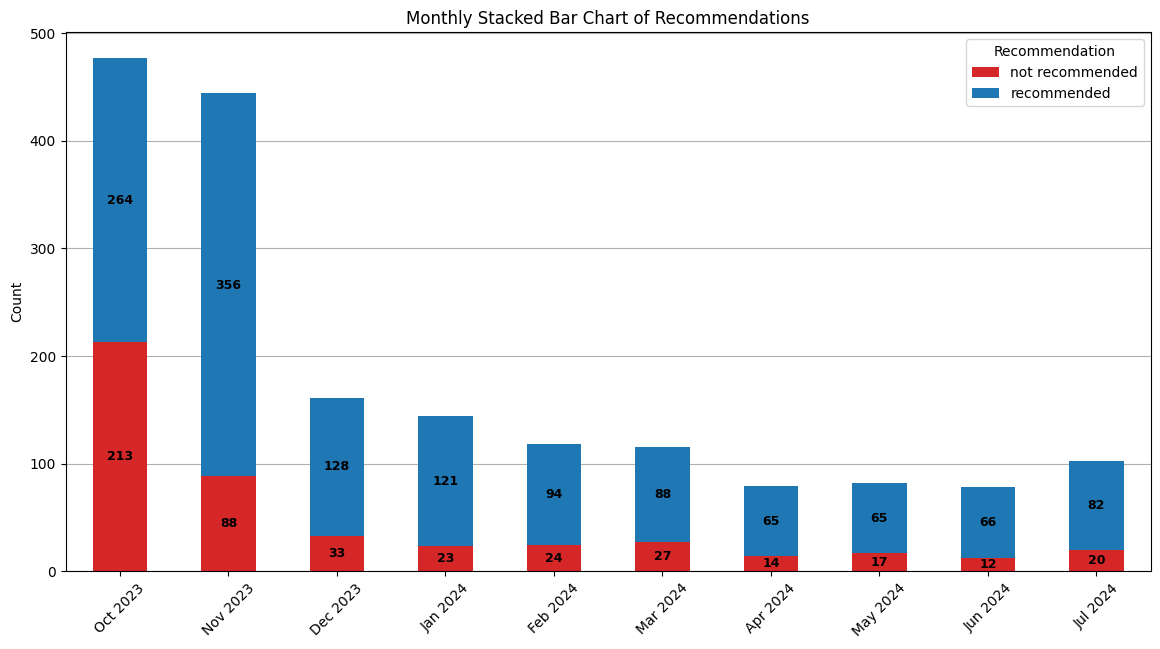

In [4]:
# Extract year and month for grouping
df['month_year'] = df['review_date'].dt.to_period('M')

# Count the recommendations per month
monthly_recommendation_counts = df.groupby(['month_year', 'recommendation']).size().unstack().fillna(0)

# Plot the stacked bar chart
ax = monthly_recommendation_counts.plot(kind='bar', stacked=True, figsize=(14, 7), color=['tab:red', 'tab:blue'])
ax.set_title('Monthly Stacked Bar Chart of Recommendations')
ax.set_ylabel('Count')
ax.set_xlabel('')
ax.set_xticklabels([f'{period.start_time.strftime("%b %Y")}' for period in monthly_recommendation_counts.index], rotation=45)
ax.legend(title='Recommendation')
ax.set_axisbelow(True)
plt.grid(axis='y')

# Annotate the counts on the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.), ha='center', va='center', xytext=(0, 0), textcoords='offset points', fontsize=9, color='black', weight='bold')

plt.show()

A stacked bar chart was created to show the monthly counts of recommended and not recommended reviews. Most of the reviews were submitted in the first two months, with a noticeable stagnation in subsequent months, likely due to the lack of significant updates to the game.

### Playtime at Review

In [5]:
# Create a variable for playtime in hours
playhrs = df['playtime_at_review'] / 60
playhrs.describe()

count    1800.000000
mean       10.966444
std        13.693124
min         0.083333
25%         2.566667
50%         9.066667
75%        15.037500
max       291.366667
Name: playtime_at_review, dtype: float64

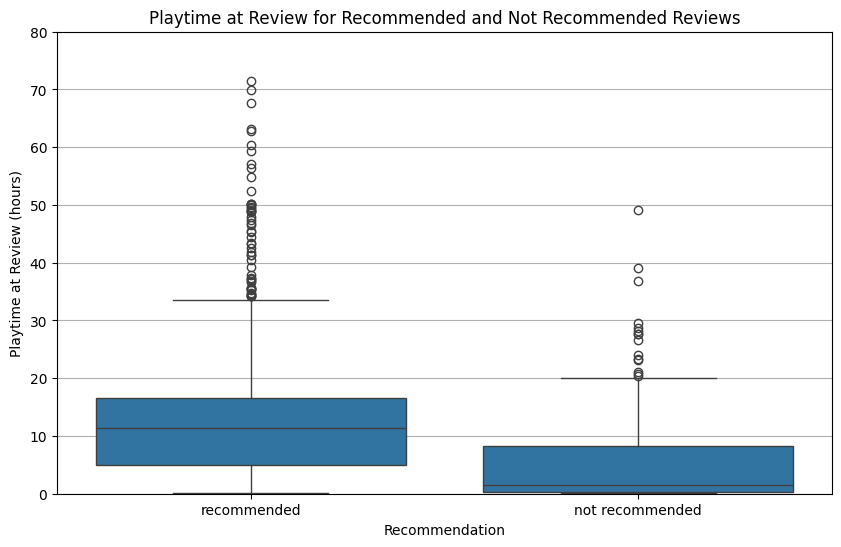

In [6]:
# Create the boxplot for playtime at review for recommended and not recommended reviews
plt.figure(figsize=(10, 6))
sns.boxplot(x='recommendation', y=playhrs, data=df)
plt.xlabel('Recommendation')
plt.ylabel('Playtime at Review (hours)')
plt.title('Playtime at Review for Recommended and Not Recommended Reviews')
plt.ylim(0,80)
plt.grid(axis='y')
plt.show()

The analysis showed that recommended reviews generally had higher playtime, indicating that users who spent more time playing the game were more likely to recommend it. On the contrary, users who did not enjoy the game tended to spend less time playing before leaving a negative review.

### Language Review Count

In [7]:
# Review counts by language
review_counts_by_language = df['language'].value_counts()
print(review_counts_by_language)

language
english       1249
spanish        149
french          73
german          51
italian         48
japanese        38
brazilian       37
latam           32
russian         29
turkish         25
polish          23
czech            7
schinese         7
koreana          6
dutch            4
ukrainian        4
finnish          3
tchinese         3
hungarian        3
portuguese       3
swedish          2
danish           2
thai             1
norwegian        1
Name: count, dtype: int64


Most reviews were in English, followed by Spanish and French.

# Natural Language Processing

For the Natural Language Processing analysis, the focus will be exclusively on English reviews. The data will be filtered using the Steam language information. However, this method is not entirely accurate because some English reviews are listed under other languages, and some foreign language reviews are listed as English. <br> To achieve more accurate filtering, language detection libraries such as "langdetect" or "lingua" could be utilized

For the sentiment analysis, VADER and RoBERTa will be employed to analyze the reviews, and their results will be compared.

In [8]:
# Filter the dataset
df = df[df.language == 'english']

## VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool designed to effectively analyze sentiments expressed in text. VADER provides four sentiment scores: Negative, Neutral, Positive, and Compound. The Compound score is a normalized, weighted composite score ranging from -1 (most negative) to +1 (most positive). This score is calculated by summing the valence scores of each word in the lexicon and normalizing the result to fall between -1 and 1.

In [9]:
# Ensure nltk vader lexicon are downloaded
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [10]:
vader_start_time = time.time()

# Apply VADER to each review and create new columns for the scores
df['vader_neg'] = df['review'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['vader_neu'] = df['review'].apply(lambda x: sid.polarity_scores(x)['neu'])
df['vader_pos'] = df['review'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['vader_compound'] = df['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Define sentiment based on compound score
def get_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['vader_sentiment'] = df['vader_compound'].apply(get_sentiment)

vader_end_time = time.time()
vader_time = vader_end_time - vader_start_time

In [11]:
df.head()

steamid  playtime_at_review         review_date language  \
0  76561198087178952                 882 2024-07-24 02:56:39  english   
1  76561198798779983                 771 2024-07-24 00:43:42  english   
3  76561198069601045                 635 2024-07-23 14:26:48  english   
4  76561198155945496                 247 2024-07-23 11:36:52  english   
5  76561198160647826                1100 2024-07-23 04:37:09  english   

  recommendation                                             review  \
0    recommended        It's a decent port, but it could be better.   
1    recommended  The best Quentin Tarantino film that I don't w...   
3    recommended  Undoubtedly one of the most influential video ...   
4    recommended                                           ta bueno   
5    recommended                  solid snake smoked 500 cigarettes   

  month_year  vader_neg  vader_neu  vader_pos  vader_compound vader_sentiment  
0    2024-07      0.000      0.645      0.355          0.5927        Positive  
1    2024-07      0.085      0.624      0.291          0.6096        Positive  
3    2024-07      0.000      0.813      0.187          0.7943        Positive  
4    2024-07      0.000      1.000      0.000          0.0000         Neutral  
5    2024-07      0.000      0.714      0.286          0.1531        Positive

In [12]:
# Display sentiment counts
vader_sentiment_counts = df['vader_sentiment'].value_counts()
print(f"Sentiment Distribution:\n{vader_sentiment_counts}")

Sentiment Distribution:
vader_sentiment
Positive    726
Negative    262
Neutral     261
Name: count, dtype: int64


VADER sentiment analysis showed that the majority of the reviews were positive (726), followed by negative (262), and neutral (261).

## RoBERTa

RoBERTa (A Robustly Optimized BERT Pretraining Approach) is a transformer-based model that enhances the BERT (Bidirectional Encoder Representations from Transformers) model through optimized training methodologies. The model performs sentiment analysis by examining the contextual relationships between words in a given text. RoBERTa outputs the predicted sentiment category and the associated confidence score, indicating the model's certainty in its prediction.
<br><br>
Additionally, we can extract the probabilities (logits) for each sentiment class (e.g., positive, negative, neutral). These probabilities represent the likelihood that the input text belongs to each class. From these probabilities, we can calculate a compound-like score using a weighted sum and the tanh function, providing a more nuanced sentiment analysis.

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

2024-07-31 17:22:18.516204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 17:22:18.554144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 17:22:18.562718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 17:22:18.581730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 17:22:21.185968: W tensorflow/compiler/tf2

In [14]:
# Load tokenizer, model, and the sentiment-analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, padding=True, truncation=True, max_length=512)

In [15]:
roberta_start_time = time.time()

# Function to get sentiment scores
def get_roberta_sentiment(review):
    encoded_review = tokenizer(review, return_tensors='pt', padding=True, truncation=True, max_length=512)
    output = model(**encoded_review)
    
    logits = output[0][0].detach().numpy()  # Raw logits
    probabilities = softmax(logits)  # Softmax probabilities
    # Calculate compound-like score using weighted sum and tanh
    compound_score = np.tanh(probabilities[2] * 1 + probabilities[1] * 0 + probabilities[0] * -1) 
    
    result = sentiment_pipeline(review)[0]
    label_map = {
        'LABEL_0': 'Negative',
        'LABEL_1': 'Neutral',
        'LABEL_2': 'Positive'
    }
    sentiment_label = label_map[result['label']]

    return probabilities[0], probabilities[1], probabilities[2], compound_score, sentiment_label, result['score']

# Apply the RoBERTa model to the reviews
df['roberta_neg'], df['roberta_neu'], df['roberta_pos'], df['roberta_compound'], df['roberta_sentiment'], df['roberta_score'] = zip(*df['review'].apply(get_roberta_sentiment))

roberta_end_time = time.time()

roberta_time = roberta_end_time - roberta_start_time

In [16]:
df.head()

steamid  playtime_at_review         review_date language  \
0  76561198087178952                 882 2024-07-24 02:56:39  english   
1  76561198798779983                 771 2024-07-24 00:43:42  english   
3  76561198069601045                 635 2024-07-23 14:26:48  english   
4  76561198155945496                 247 2024-07-23 11:36:52  english   
5  76561198160647826                1100 2024-07-23 04:37:09  english   

  recommendation                                             review  \
0    recommended        It's a decent port, but it could be better.   
1    recommended  The best Quentin Tarantino film that I don't w...   
3    recommended  Undoubtedly one of the most influential video ...   
4    recommended                                           ta bueno   
5    recommended                  solid snake smoked 500 cigarettes   

  month_year  vader_neg  vader_neu  vader_pos  vader_compound vader_sentiment  \
0    2024-07      0.000      0.645      0.355          0.5927        Positive   
1    2024-07      0.085      0.624      0.291          0.6096        Positive   
3    2024-07      0.000      0.813      0.187          0.7943        Positive   
4    2024-07      0.000      1.000      0.000          0.0000         Neutral   
5    2024-07      0.000      0.714      0.286          0.1531        Positive   

   roberta_neg  roberta_neu  roberta_pos  roberta_compound roberta_sentiment  \
0     0.143172     0.386522     0.470306          0.315943          Positive   
1     0.240758     0.329828     0.429413          0.186448          Positive   
3     0.005146     0.046832     0.948022          0.736541          Positive   
4     0.207345     0.610191     0.182464         -0.024876           Neutral   
5     0.799420     0.191205     0.009375         -0.658434          Negative   

   roberta_score  
0       0.470306  
1       0.429413  
3       0.948022  
4       0.610191  
5       0.799420

In [17]:
# Display sentiment counts
roberta_sentiment_counts = df['roberta_sentiment'].value_counts()
print(f"Sentiment Distribution:\n{roberta_sentiment_counts}")

Sentiment Distribution:
roberta_sentiment
Positive    550
Neutral     357
Negative    342
Name: count, dtype: int64


RoBERTa sentiment analysis showed that the majority of the reviews were positive (550), followed by neutral (357), and negative (342).

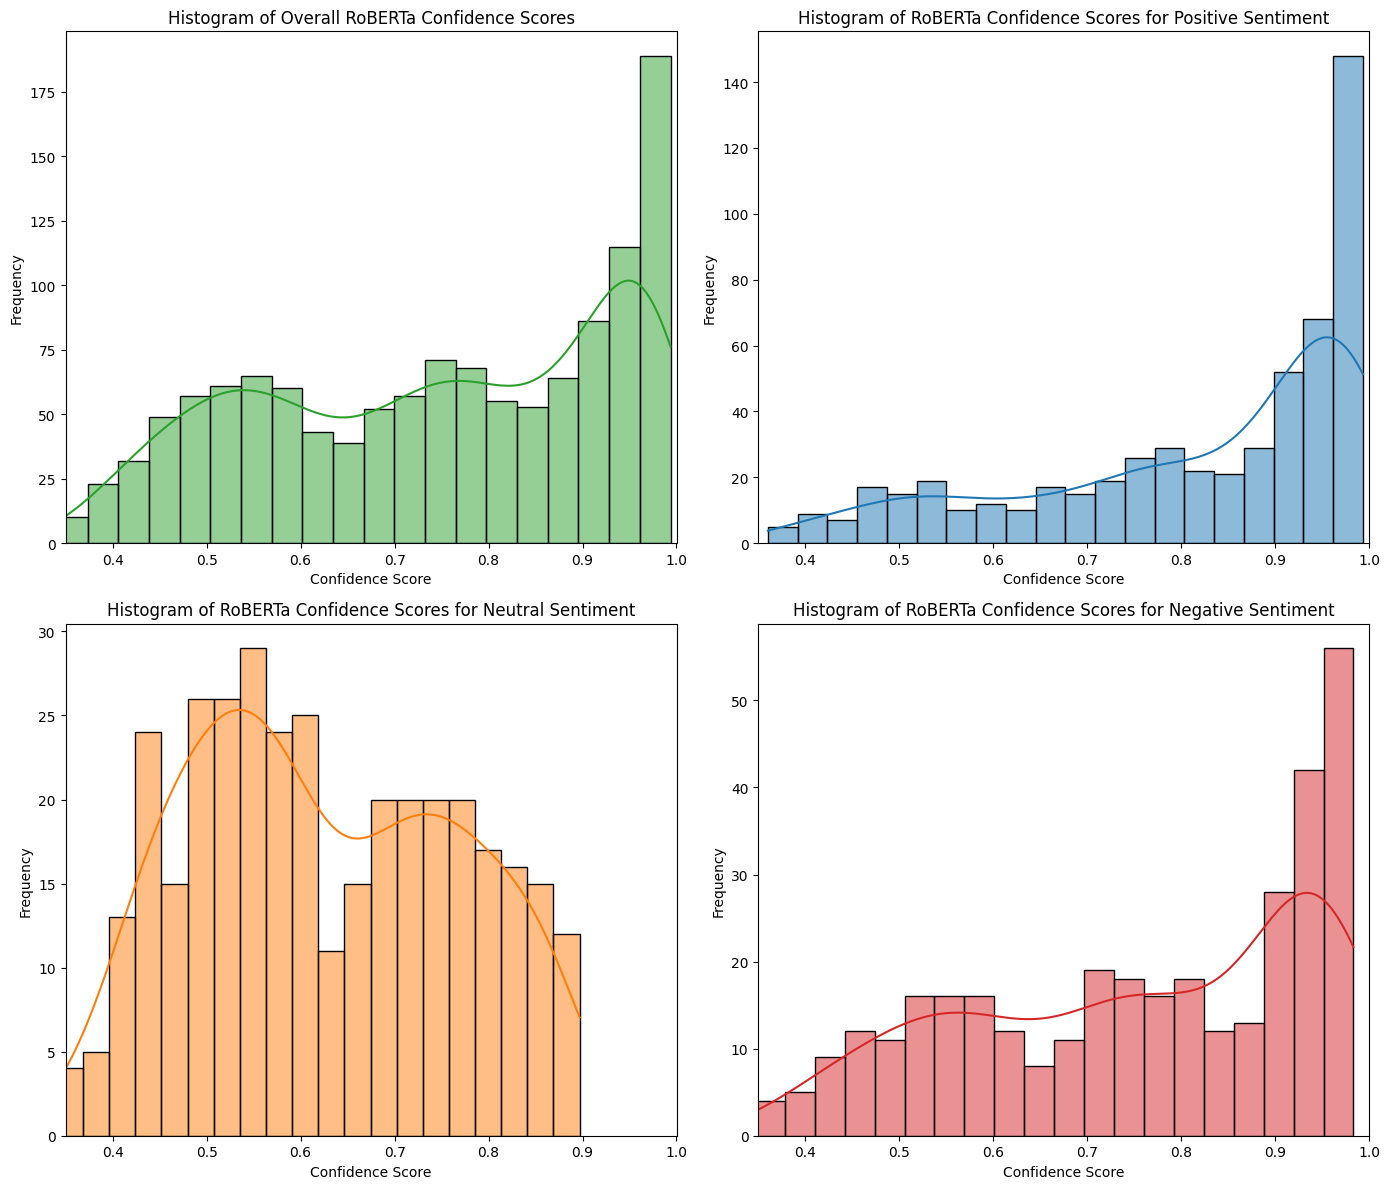

In [18]:
# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Overall histogram
sns.histplot(data=df, x='roberta_score', kde=True, bins=20, color='tab:green', ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Overall RoBERTa Confidence Scores')
axes[0, 0].set_xlabel('Confidence Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(0.35,1)

# Histogram for Positive sentiment
sns.histplot(data=df[df['roberta_sentiment'] == 'Positive'], x='roberta_score', kde=True, bins=20, color='tab:blue', ax=axes[0, 1])
axes[0, 1].set_title('Histogram of RoBERTa Confidence Scores for Positive Sentiment')
axes[0, 1].set_xlabel('Confidence Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(0.35,1)

# Histogram for Neutral sentiment
sns.histplot(data=df[df['roberta_sentiment'] == 'Neutral'], x='roberta_score', kde=True, bins=20, color='tab:orange', ax=axes[1, 0])
axes[1, 0].set_title('Histogram of RoBERTa Confidence Scores for Neutral Sentiment')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0.35,1)

# Histogram for Negative sentiment
sns.histplot(data=df[df['roberta_sentiment'] == 'Negative'], x='roberta_score', kde=True, bins=20, color='tab:red', ax=axes[1, 1])
axes[1, 1].set_title('Histogram of RoBERTa Confidence Scores for Negative Sentiment')
axes[1, 1].set_xlabel('Confidence Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0.35,1)

# Adjust layout
plt.tight_layout()
plt.show()

The confidence scores provide valuable insights into the RoBERTa model’s performance and reliability in sentiment analysis. Both positive and negative sentiments exhibit high confidence scores (0.9 to 1.0), indicating the model is often very sure when predicting these sentiments.However, neutral sentiment shows a more spread-out distribution with moderate confidence levels, suggesting more uncertainty in these predictions highlighting areas for potential improvement. The overall distribution reflects the trends seen in the individual sentiment categories, with a notable cluster of high-confidence predictions and a spread of moderate confidence scores.

## Comparison and Analysis

### Execution Time Comparison

In [19]:
print(f"VADER process took {vader_time:.2f} seconds")
print(f"RoBERTa process took {roberta_time:.2f} seconds")

VADER process took 2.74 seconds
RoBERTa process took 315.40 seconds


The RoBERTa model takes significantly longer to process than the VADER model, highlighting the computational complexity of RoBERTa. While VADER can process text quickly due to its rule-based and lexicon-driven approach, RoBERTa, being a transformer-based model, requires more computational resources and time. This complexity is a trade-off for the nuanced and context-aware predictions that RoBERTa provides.

### Steam Recommendation and Sentiment Comparison

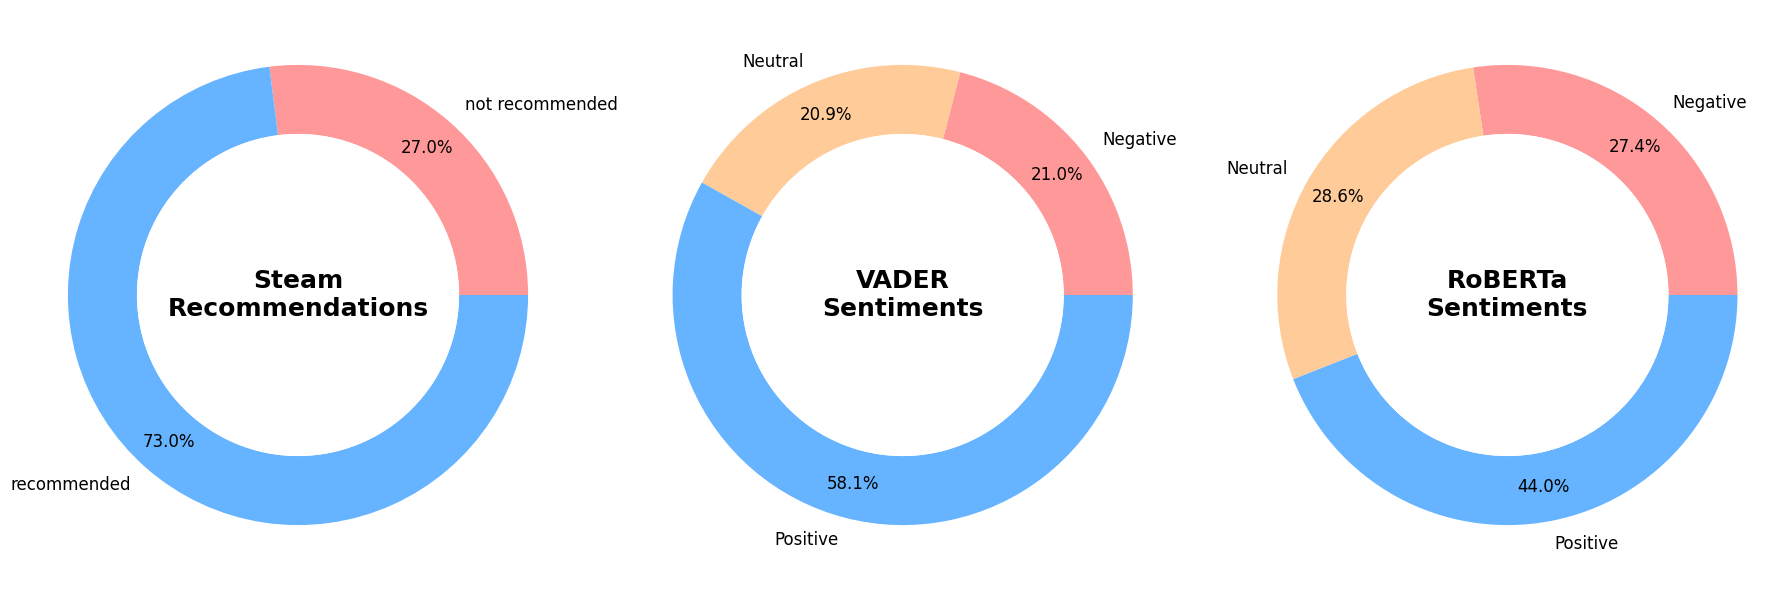

Cohen's Kappa Score: 0.5261585814790576


In [20]:
from sklearn.metrics import cohen_kappa_score

# Function to create a donut chart with title inside the donut
def create_donut_chart(ax, data, labels, title, colors):
    wedges, texts, autotexts = ax.pie(data, labels=labels, colors=colors, autopct='%1.1f%%',
                                     startangle=0, pctdistance=0.85, wedgeprops=dict(width=0.3))
    for text in texts:
        text.set_fontsize(12)
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_color('black')
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    # Add the title inside the donut
    ax.text(0, 0, title, horizontalalignment='center', verticalalignment='center', fontsize=18, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Prepare data for Steam recommendation
steam_recommendation_counts = df['recommendation'].value_counts()
steam_labels = ['not recommended', 'recommended']
steam_data = [steam_recommendation_counts.get(label, 0) for label in steam_labels]
steam_colors = ['#ff9999', '#66b3ff']  # Red for not recommended, blue for recommended

# Prepare data for VADER sentiment
vader_sentiment_counts = df['vader_sentiment'].value_counts()
vader_labels = ['Negative', 'Neutral', 'Positive']
vader_data = [vader_sentiment_counts.get(label, 0) for label in vader_labels]
vader_colors = ['#ff9999', '#ffcc99', '#66b3ff']  # Red for negative, light orange for neutral, blue for positive

# Prepare data for RoBERTa sentiment
roberta_sentiment_counts = df['roberta_sentiment'].value_counts()
roberta_labels = ['Negative', 'Neutral', 'Positive']
roberta_data = [roberta_sentiment_counts.get(label, 0) for label in roberta_labels]
roberta_colors = ['#ff9999', '#ffcc99', '#66b3ff']  # Red for negative, light orange for neutral, blue for positive

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Create donut charts
create_donut_chart(axs[0], steam_data, steam_labels, 'Steam\nRecommendations', steam_colors)
create_donut_chart(axs[1], vader_data, vader_labels, 'VADER\nSentiments', vader_colors)
create_donut_chart(axs[2], roberta_data, roberta_labels, 'RoBERTa\nSentiments', roberta_colors)

plt.tight_layout()
plt.show()

#Calculate Cohen's Kappa
kappa = cohen_kappa_score(df['vader_sentiment'], df['roberta_sentiment'])
print(f"Cohen's Kappa Score: {kappa}")

While 73% of players on of Metal Gear Solid on Steam leaves a "Recommended" review, both VADER and RoBERTa sentiment analysis shows a lower percentage of positive sentiment (58% and 44%, respectively). The lower percentage of positive sentiment in both model indicates that while user generally liked the games, many neutral and negative sentiments can be found in the reviews. The discrepancy between VADER and RoBERTa scores suggests that RoBERTa may be detecting more complexity in user sentiments, potentially identifying subtle negative tones in otherwise positive reviews.

A Cohen's Kappa score of 0.526 suggests a moderate level of agreement between the VADER and RoBERTa sentiment classifications (Landis & Koch, 1977). While there is some level of consistency between the VADER and RoBERTa models' sentiment classifications, there is still room for improvement.

### Sentiment Over Time

#### Average Monthly Sentiment Score

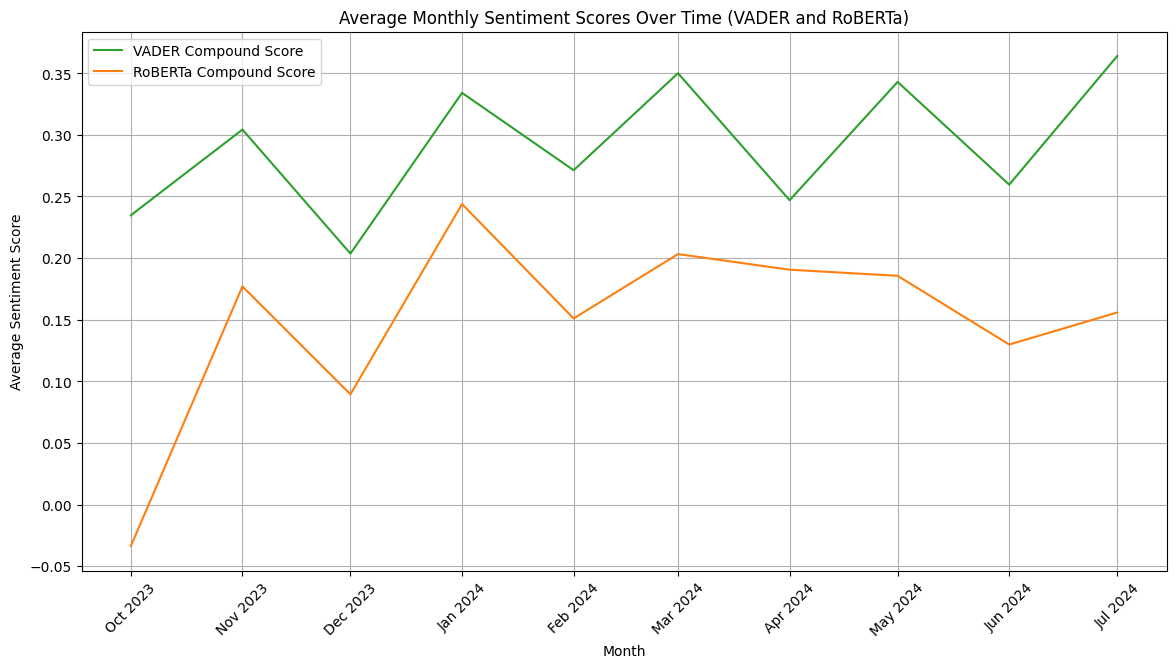

In [21]:
# Calculate average sentiment scores by month for VADER and RoBERTa
monthly_sentiments = df.groupby('month_year').agg({
    'vader_compound': 'mean',
    'roberta_compound': 'mean'
}).reset_index()

# Convert month_year back to datetime for plotting
monthly_sentiments['month_year'] = monthly_sentiments['month_year'].dt.to_timestamp()

# Plot average sentiment scores by month for VADER and RoBERTa
plt.figure(figsize=(14, 7))
plt.plot(monthly_sentiments['month_year'], monthly_sentiments['vader_compound'], label='VADER Compound Score', color='tab:green')
plt.plot(monthly_sentiments['month_year'], monthly_sentiments['roberta_compound'], label='RoBERTa Compound Score', color='tab:orange')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.title('Average Monthly Sentiment Scores Over Time (VADER and RoBERTa)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.xticks(monthly_sentiments['month_year'], [date.strftime('%b %Y') for date in monthly_sentiments['month_year']], rotation=45)
plt.show()

Both VADER and RoBERTa models show relatively positive sentiment trends with minor fluctuations over time. VADER's sentiment scores are consistently higher than RoBERTa's, suggesting that RoBERTa provides a more nuanced understanding of the text. A notable point of interest is October 2023, the month when the game was released. During this period, RoBERTa's sentiment scores are in the negative range, coinciding with the highest review count, indicating a more critical reception immediately following the game's launch.

#### Cumulative Mean Monthly Sentiment Score

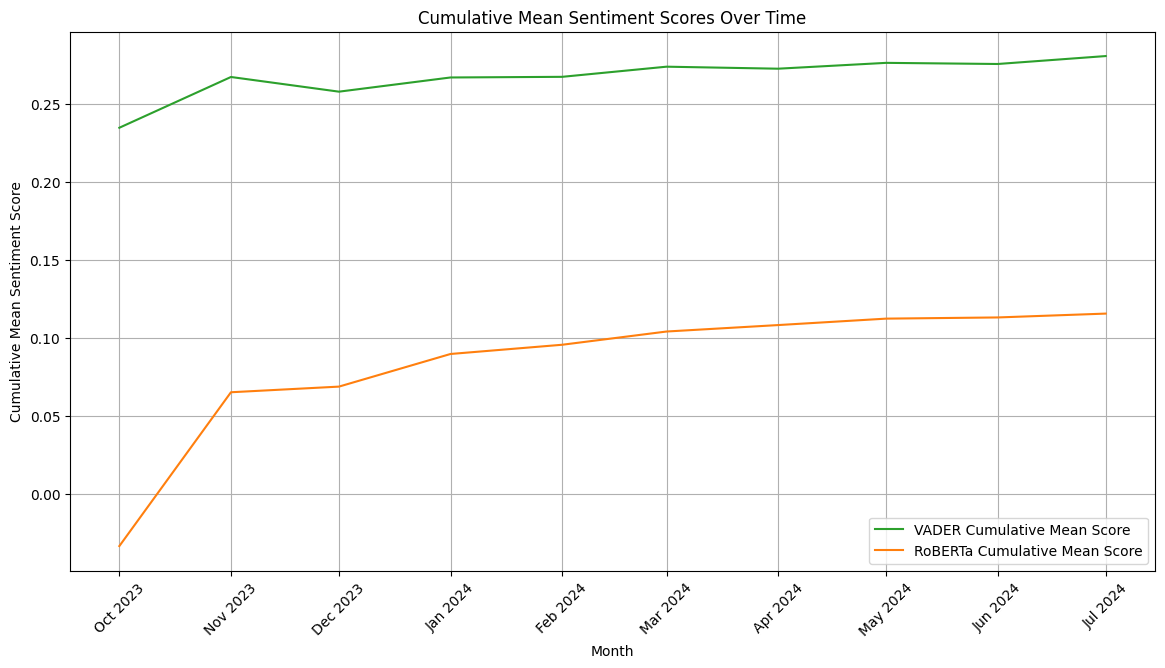

In [22]:
# Calculate the sum and count of sentiment scores by month for VADER and RoBERTa
monthly_sentiments = df.groupby('month_year').agg({
    'vader_compound': ['sum', 'count'],
    'roberta_compound': ['sum', 'count']
}).reset_index()

# Flatten the column multi-index
monthly_sentiments.columns = ['month_year', 'vader_sum', 'vader_count', 'roberta_sum', 'roberta_count']

# Calculate the cumulative sum and count of sentiment scores
monthly_sentiments['vader_cumulative_sum'] = monthly_sentiments['vader_sum'].cumsum()
monthly_sentiments['vader_cumulative_count'] = monthly_sentiments['vader_count'].cumsum()
monthly_sentiments['roberta_cumulative_sum'] = monthly_sentiments['roberta_sum'].cumsum()
monthly_sentiments['roberta_cumulative_count'] = monthly_sentiments['roberta_count'].cumsum()

# Calculate the cumulative mean of sentiment scores
monthly_sentiments['vader_cumulative_mean'] = monthly_sentiments['vader_cumulative_sum'] / monthly_sentiments['vader_cumulative_count']
monthly_sentiments['roberta_cumulative_mean'] = monthly_sentiments['roberta_cumulative_sum'] / monthly_sentiments['roberta_cumulative_count']

# Convert month_year back to datetime for plotting
monthly_sentiments['month_year'] = monthly_sentiments['month_year'].dt.to_timestamp()

# Plot cumulative mean VADER and RoBERTa compound scores over time
plt.figure(figsize=(14, 7))
plt.plot(monthly_sentiments['month_year'], monthly_sentiments['vader_cumulative_mean'], label='VADER Cumulative Mean Score', color='tab:green')
plt.plot(monthly_sentiments['month_year'], monthly_sentiments['roberta_cumulative_mean'], label='RoBERTa Cumulative Mean Score', color='tab:orange')
plt.xlabel('Month')
plt.ylabel('Cumulative Mean Sentiment Score')
plt.title('Cumulative Mean Sentiment Scores Over Time')
plt.legend()
plt.grid(True)
plt.xticks(monthly_sentiments['month_year'], [date.strftime('%b %Y') for date in monthly_sentiments['month_year']], rotation=45)
plt.show()

For the cumulative mean sentiment scores, both VADER and RoBERTa show stable trends over time. This stability is likely due to the fact that most reviews were posted within the first two months of the game's release, and there have been no significant updates or major sales events to alter the sentiment or attract a large influx of new players.

### Sentiment Score Comparison

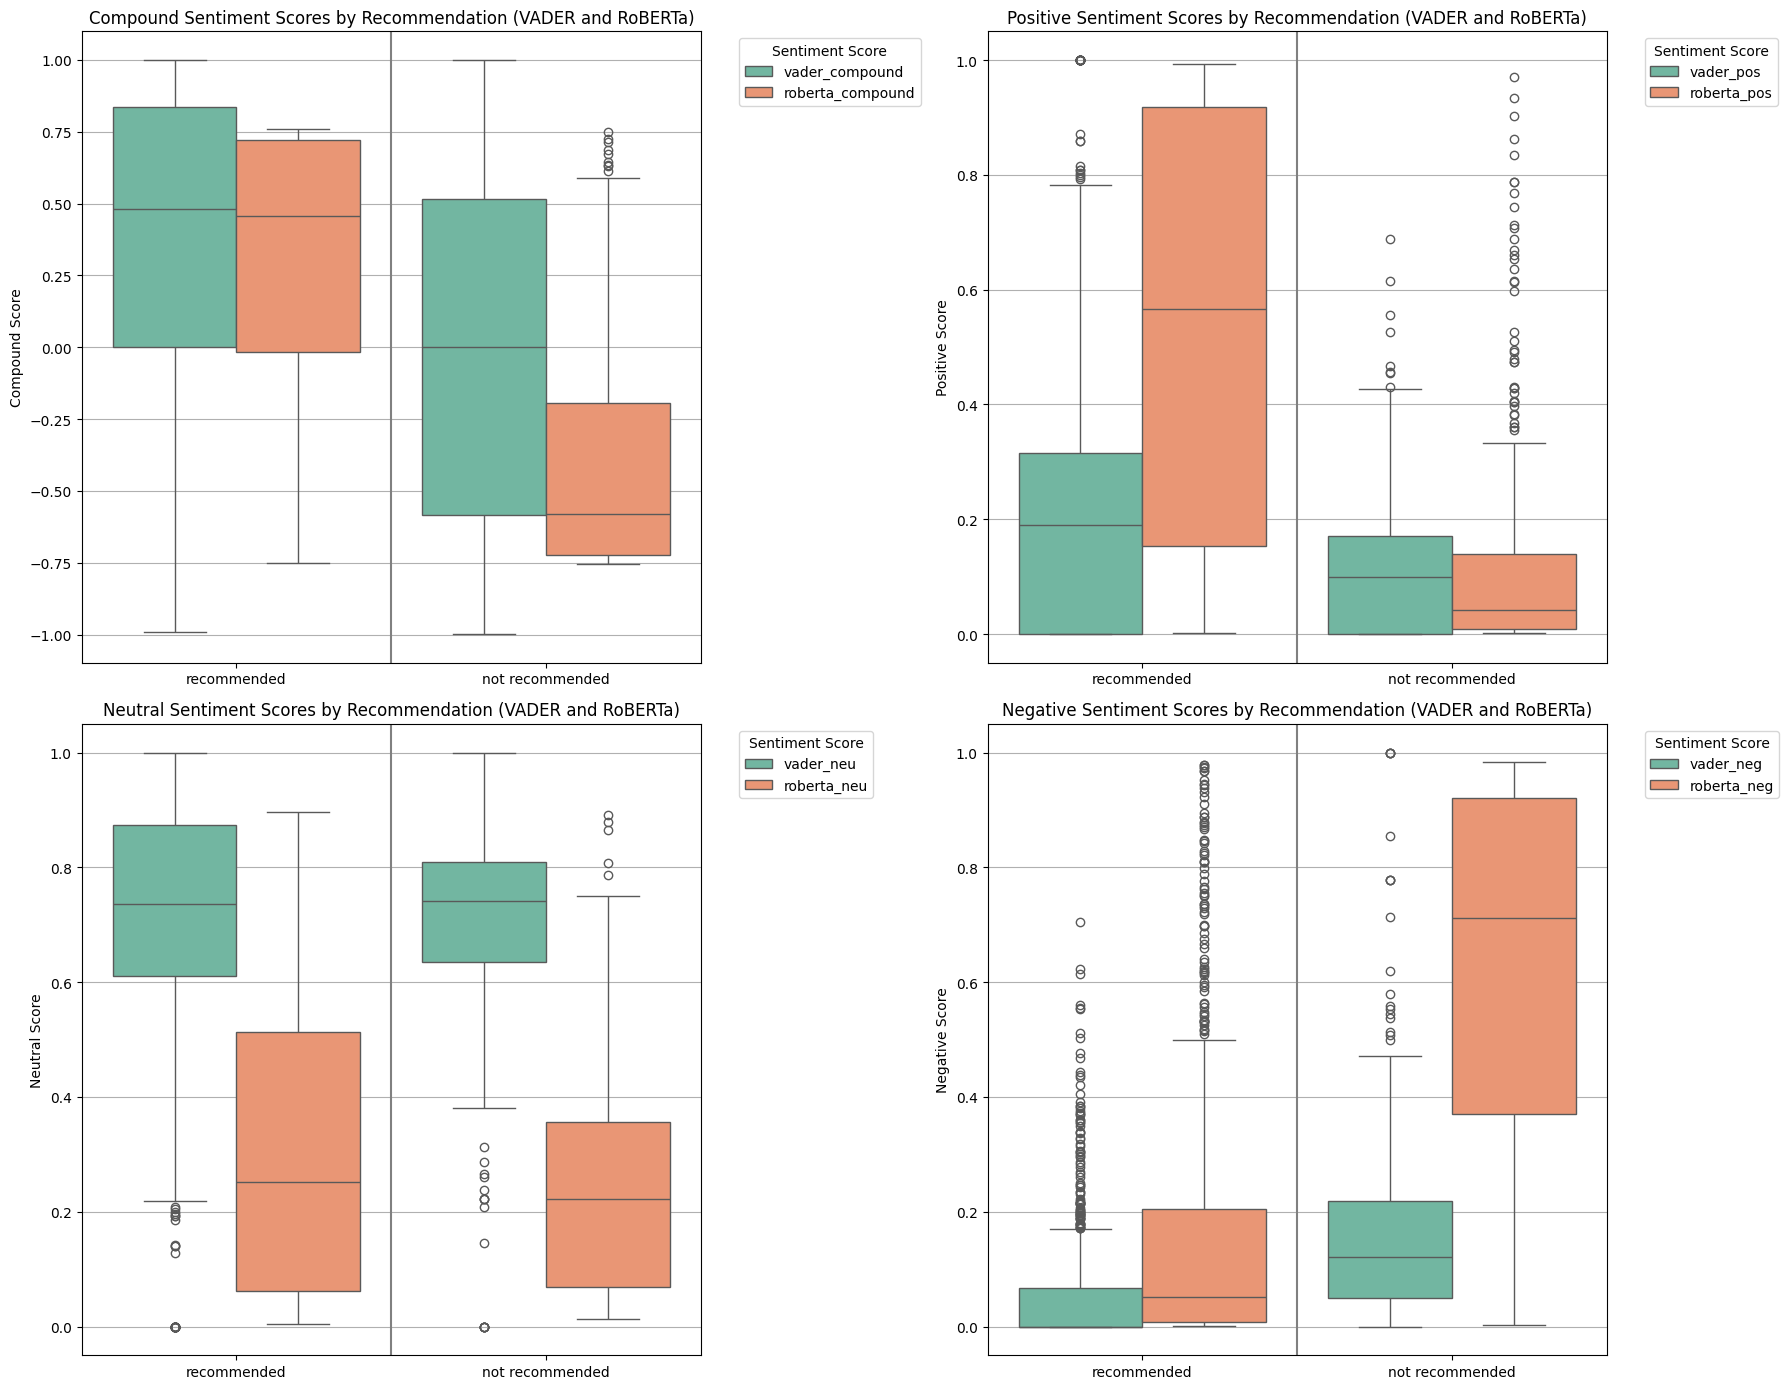

In [23]:
# Melt the DataFrame to have a long format for seaborn's boxplot
df_melted_neg = df.melt(id_vars=['recommendation'], value_vars=['vader_neg', 'roberta_neg'], var_name='Sentiment_Score', value_name='Score')
df_melted_neu = df.melt(id_vars=['recommendation'], value_vars=['vader_neu', 'roberta_neu'], var_name='Sentiment_Score', value_name='Score')
df_melted_pos = df.melt(id_vars=['recommendation'], value_vars=['vader_pos', 'roberta_pos'], var_name='Sentiment_Score', value_name='Score')
df_melted_compound = df.melt(id_vars=['recommendation'], value_vars=['vader_compound', 'roberta_compound'], var_name='Sentiment_Score', value_name='Score')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot for compound sentiment
sns.boxplot(ax=axes[0, 0], x='recommendation', y='Score', hue='Sentiment_Score', data=df_melted_compound, palette='Set2')
axes[0, 0].set_title('Compound Sentiment Scores by Recommendation (VADER and RoBERTa)')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Compound Score')
axes[0, 0].legend(title='Sentiment Score', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(axis='y')
axes[0, 0].axvline(x=0.5, color='gray')

# Plot for positive sentiment
sns.boxplot(ax=axes[0, 1], x='recommendation', y='Score', hue='Sentiment_Score', data=df_melted_pos, palette='Set2')
axes[0, 1].set_title('Positive Sentiment Scores by Recommendation (VADER and RoBERTa)')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Positive Score')
axes[0, 1].legend(title='Sentiment Score', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(axis='y')
axes[0, 1].axvline(x=0.5, color='gray')

# Plot for neutral sentiment
sns.boxplot(ax=axes[1, 0], x='recommendation', y='Score', hue='Sentiment_Score', data=df_melted_neu, palette='Set2')
axes[1, 0].set_title('Neutral Sentiment Scores by Recommendation (VADER and RoBERTa)')
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Neutral Score')
axes[1, 0].legend(title='Sentiment Score', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(axis='y')
axes[1, 0].axvline(x=0.5, color='gray')

# Plot for negative sentiment
sns.boxplot(ax=axes[1, 1], x='recommendation', y='Score', hue='Sentiment_Score', data=df_melted_neg, palette='Set2')
axes[1, 1].set_title('Negative Sentiment Scores by Recommendation (VADER and RoBERTa)')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Negative Score')
axes[1, 1].legend(title='Sentiment Score', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(axis='y')
axes[1, 1].axvline(x=0.5, color='gray')

# Adjust layout
plt.tight_layout()
plt.show()

The compound score of VADER is consistently higher than that of RoBERTa. RoBERTa's score is significantly higher for positive sentiment in recommended reviews and for negative sentiment in not recommended reviews compared to VADER. However, RoBERTa's neutral scores are lower than VADER's. This reflects RoBERTa's confidence scores and indicates its ability to capture more nuanced sentiments. The distribution of RoBERTa's scores is generally broader in individual sentiment, further demonstrating its understanding of the text.

### Compound Score Density

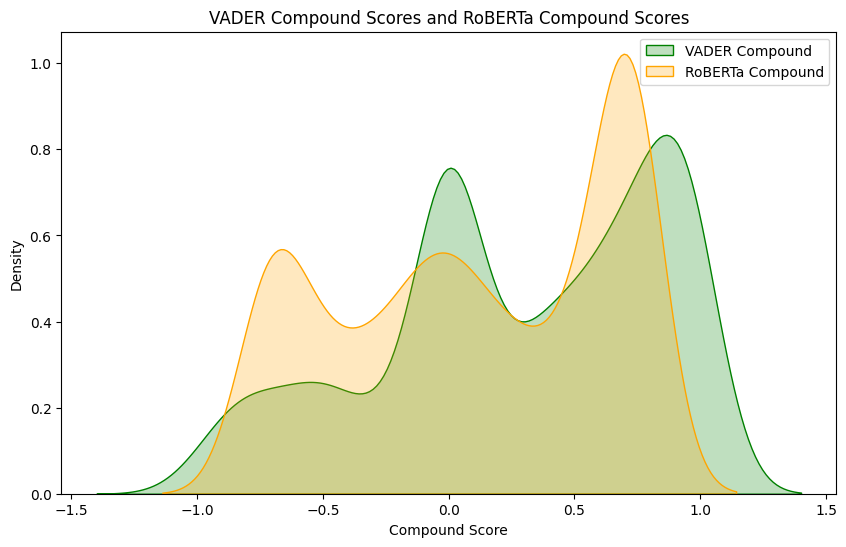

In [24]:
# Create the density plot for VADER Compound Scores and RoBERTa Compound Scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['vader_compound'], fill=True, color='green', label='VADER Compound')
sns.kdeplot(df['roberta_compound'], fill=True, color='orange', label='RoBERTa Compound')
plt.title('VADER Compound Scores and RoBERTa Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.legend()
plt.show()

The density plot shows that VADER's compound scores have a wider distribution compared to RoBERTa's. This wider distribution indicates VADER's tendency to polarize sentiment classification, resulting in a higher frequency of extreme scores. Conversely, RoBERTa's tighter distribution suggests that it is more conservative in assigning extreme sentiment scores. RoBERTa is more likely to identify sentiments as moderately positive or negative, reflecting a more nuanced and refined analysis of the reviews.

The plot also reveals that VADER has a higher peak at the neutral range (close to 0.0), indicating that it frequently classifies reviews as neutral. Interestingly, when looking at the overall sentiment classification, RoBERTa has more reviews classified as neutral. This suggests that while VADER assigns a strong neutral score to a concentrated group of reviews, RoBERTa identifies a larger number of reviews with moderate, balanced sentiments, even if they don't all cluster tightly around the exact neutral score. This difference reflects RoBERTa's nuanced approach to sentiment analysis, capturing a broader range of neutral sentiments across the reviews.

It should also be noted that RoBERTa performs the sentiment classification inherently within its model, whereas VADER's classification is determined by its compound score. In our analysis, we defined VADER's classifications with a threshold: scores above 0.5 are considered positive, scores below -0.5 are considered negative, and scores in between are classified as neutral. This methodological difference may contribute to the observed variations in sentiment classification between the two models.

### Sentiment Score Pairplot

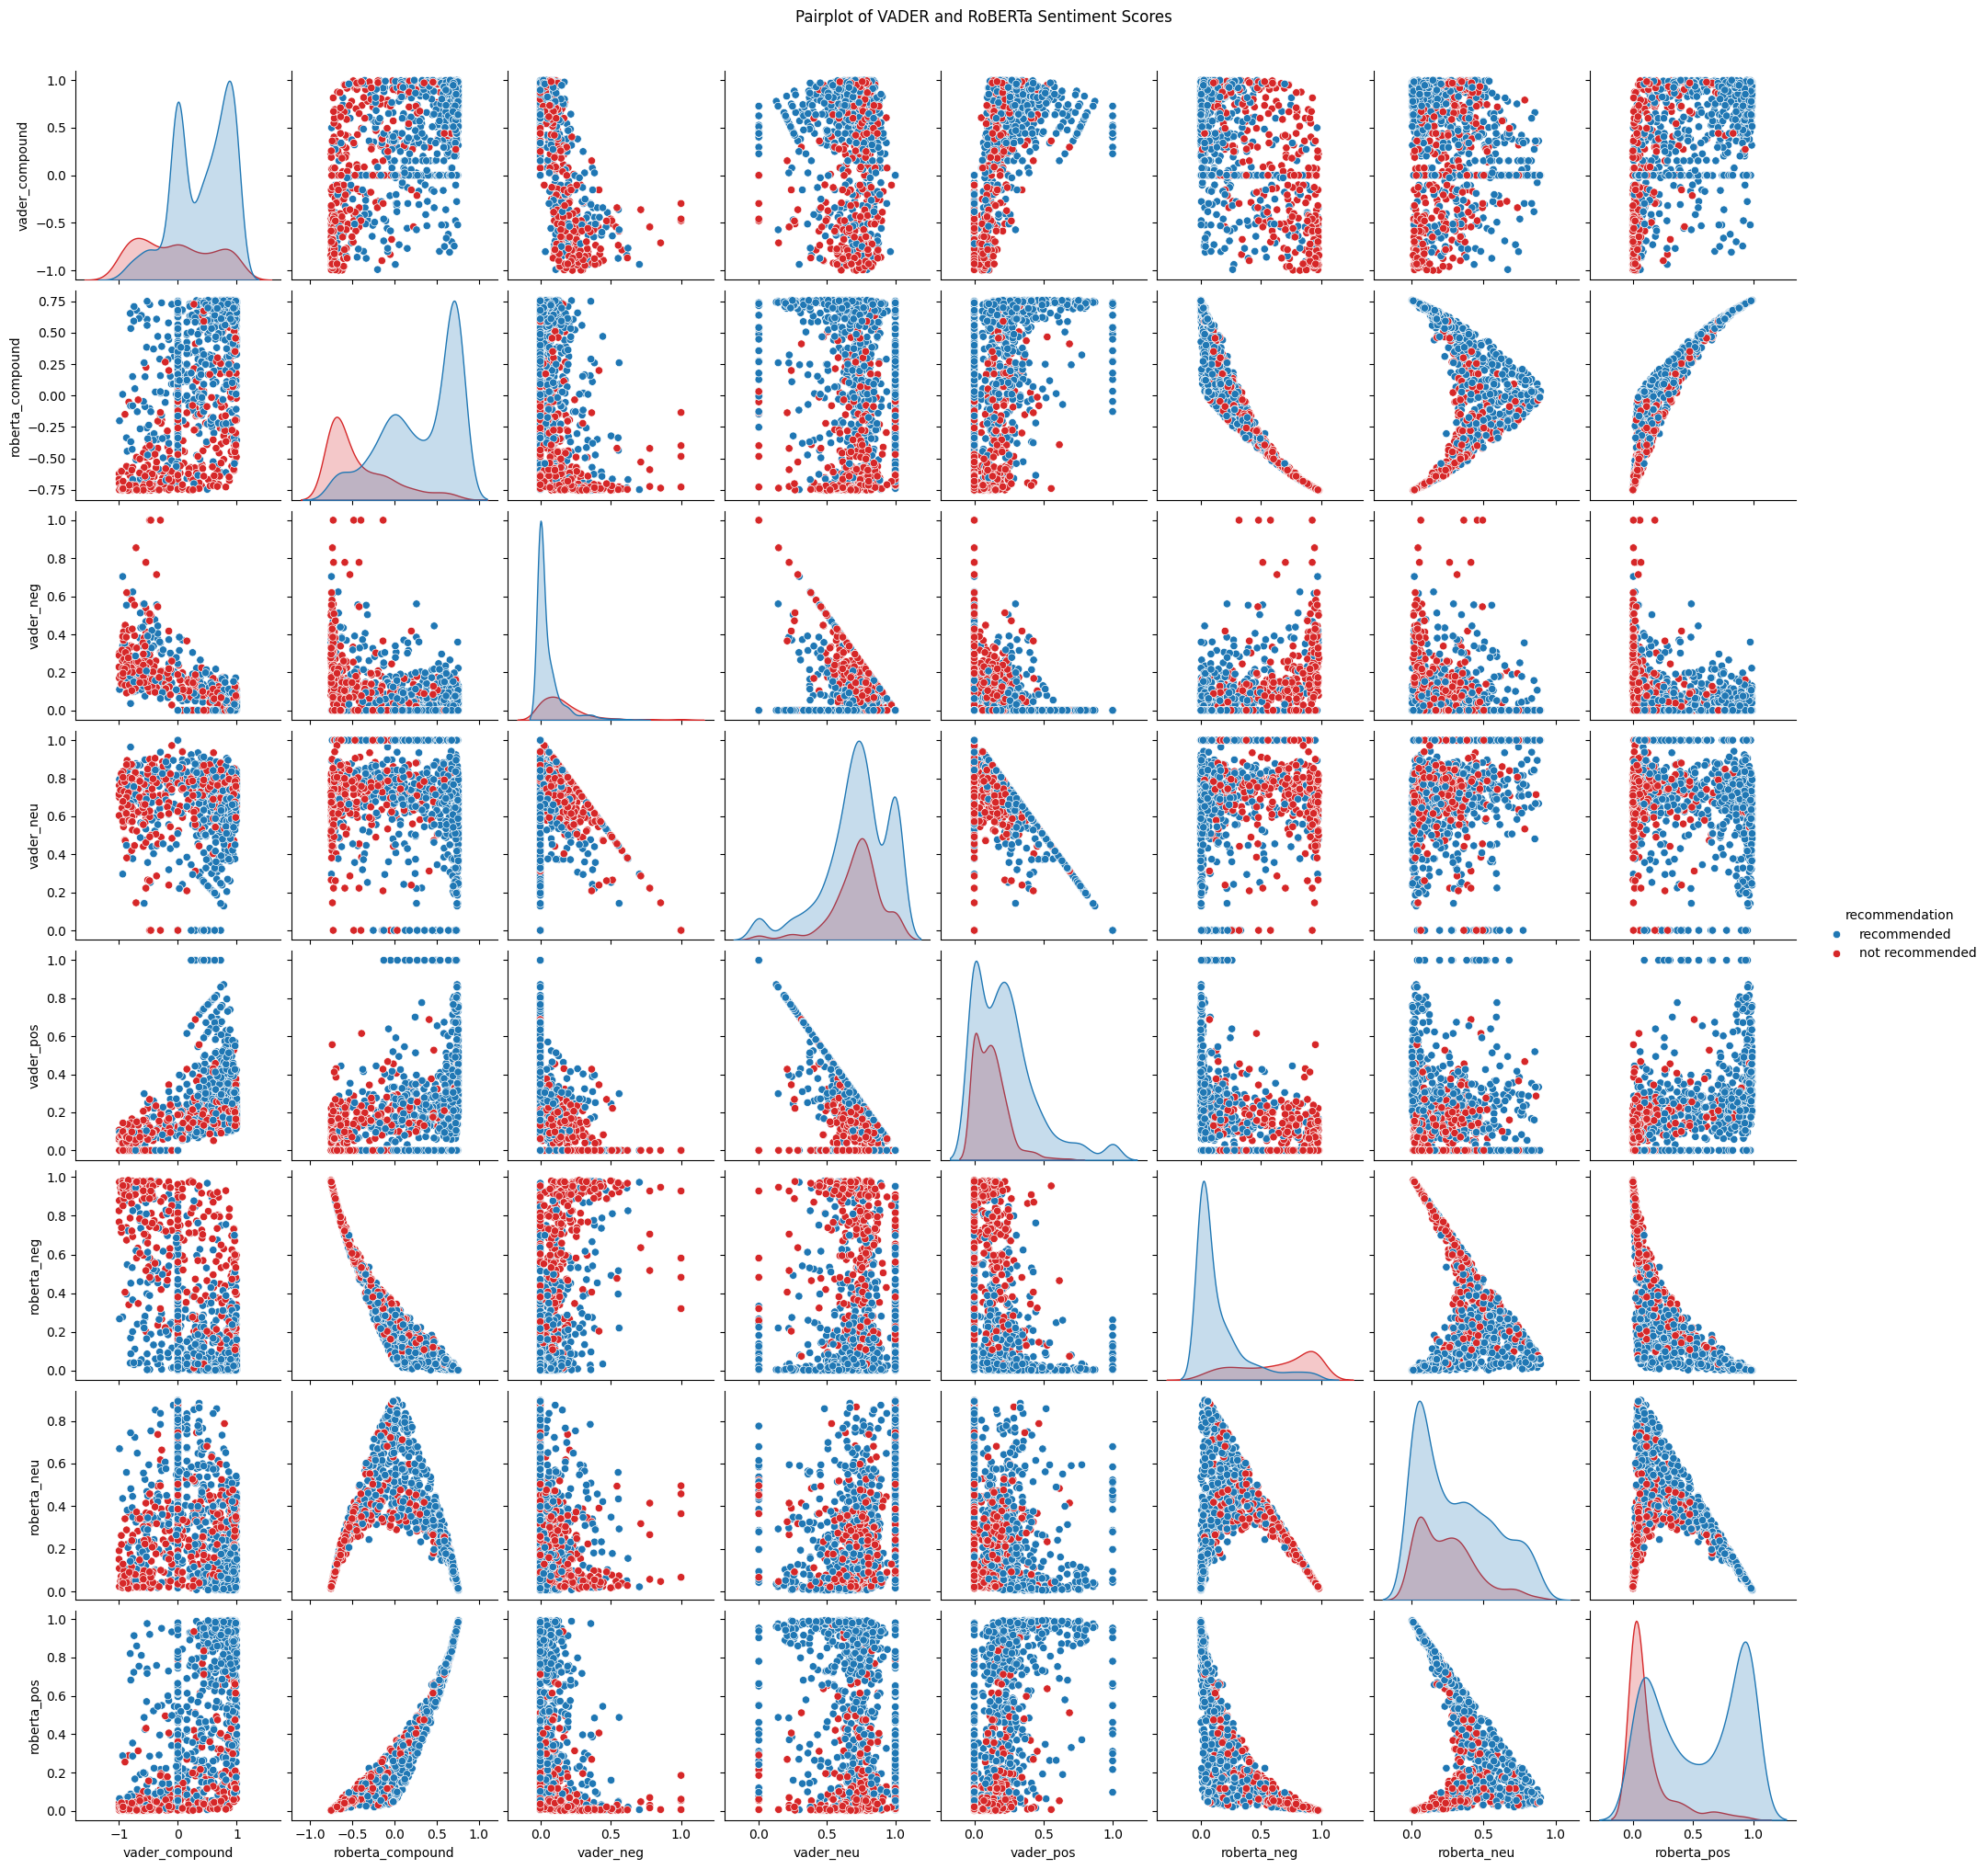

In [25]:
# Combine and compare VADER on RoBERTa results on a pairplot
pairplot = sns.pairplot(df[['vader_compound', 'roberta_compound', 'vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos', 'recommendation']],
                        hue='recommendation', palette={'recommended': 'tab:blue', 'not recommended': 'tab:red'}, diag_kind='kde')

pairplot.fig.suptitle('Pairplot of VADER and RoBERTa Sentiment Scores', y=1.02)
pairplot.savefig('pairplot_vader_roberta_sentiment_scores.png')
plt.show()

The pairplot highlights the complementary strengths of VADER and RoBERTa in sentiment analysis. VADER tends to classify sentiments more distinctly into positive, neutral, or negative categories, while RoBERTa captures more nuanced variations in sentiment. Both models align well with the Steam recommendations, showing higher positive scores for recommended reviews and higher negative scores for not recommended reviews. The differences in distribution and correlation between the models underscore the value of using multiple sentiment analysis tools to gain a comprehensive understanding of user sentiments.

### Sentiment Score Correlation

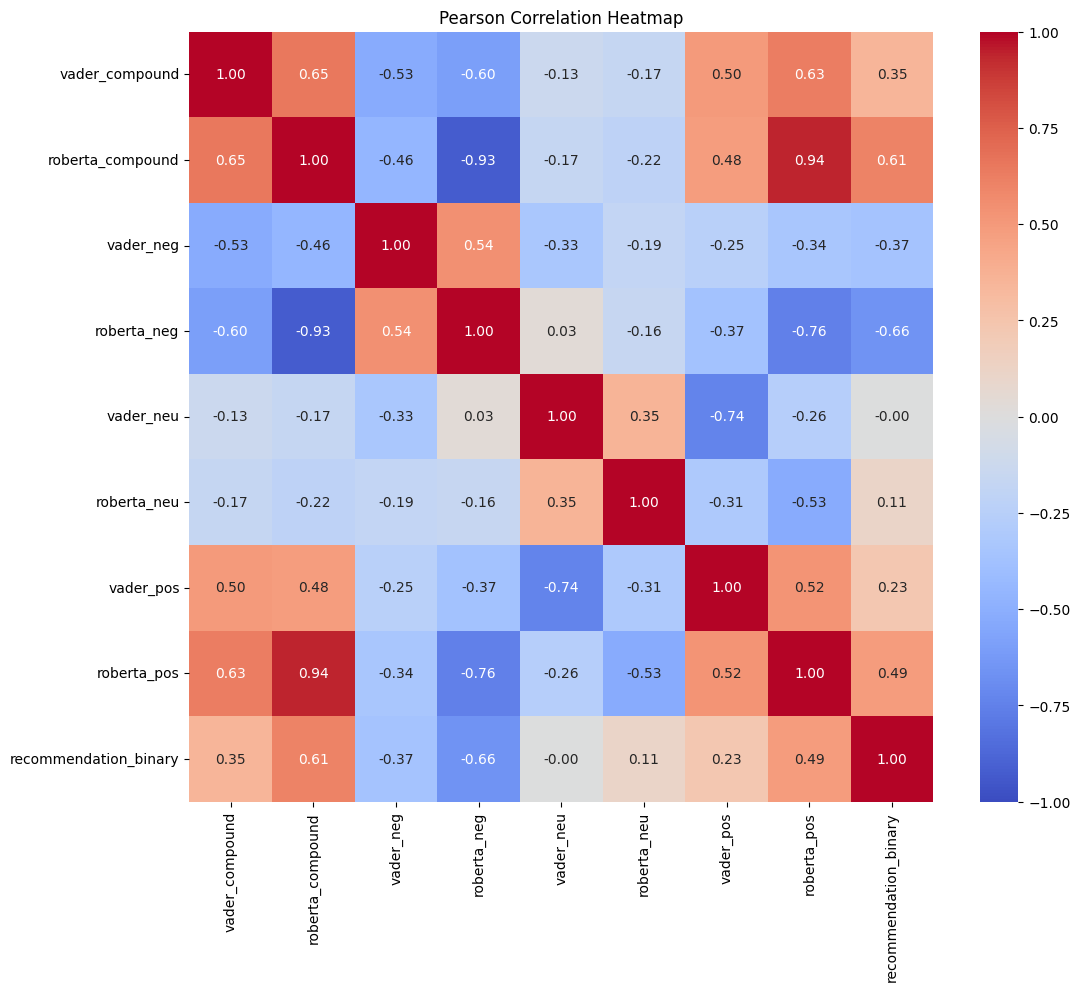

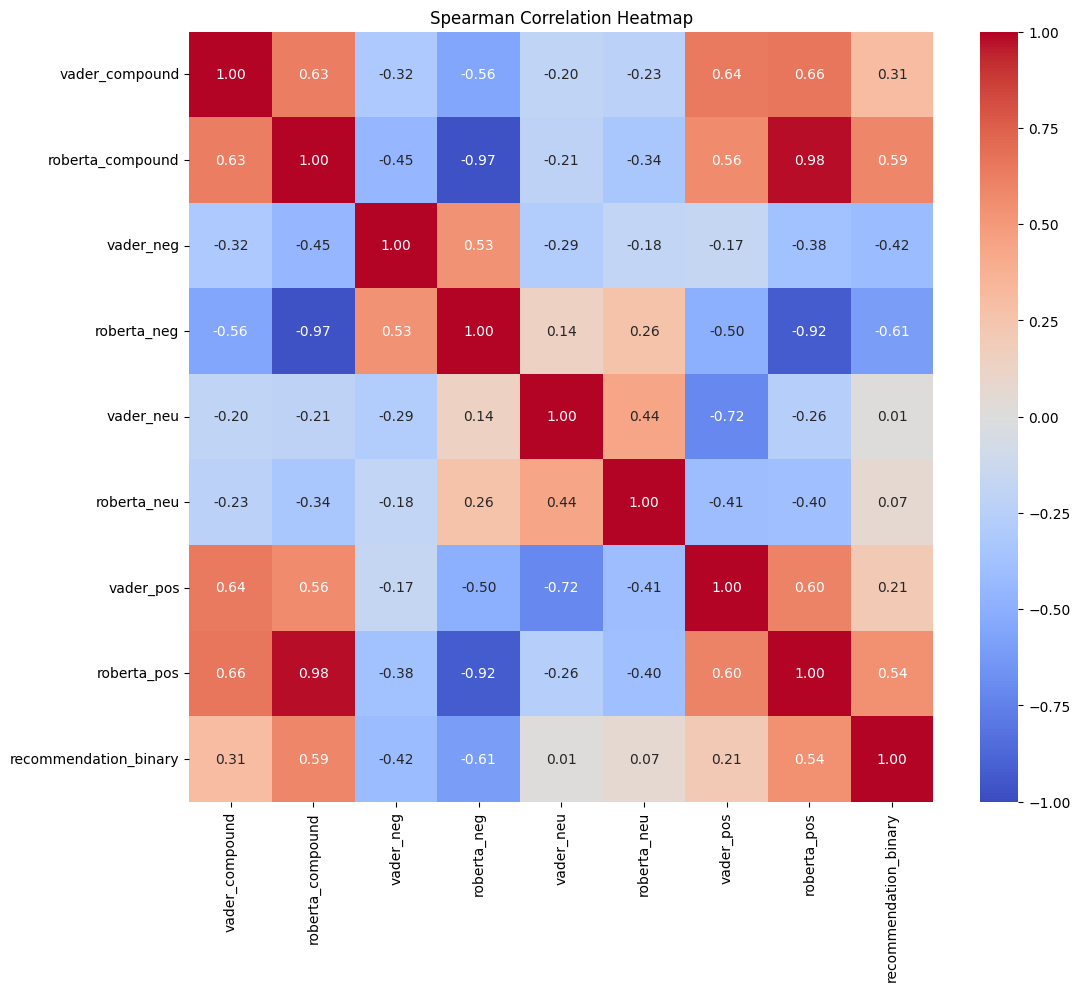

Key Correlation Coefficients (Pearson):
                  vader_compound  roberta_compound  recommendation_binary
vader_compound          1.000000          0.649418               0.348703
roberta_compound        0.649418          1.000000               0.605514

Key Correlation Coefficients (Spearman):
                  vader_compound  roberta_compound  recommendation_binary
vader_compound          1.000000          0.628814               0.307462
roberta_compound        0.628814          1.000000               0.588368


In [26]:
# Convert Steam recommendations to binary values for correlation analysis
df['recommendation_binary'] = df['recommendation'].map({'recommended': 1, 'not recommended': 0})

# Calculate Pearson correlation coefficients
pearson_correlations = df[['vader_compound', 'roberta_compound', 'vader_neg', 'roberta_neg', 'vader_neu', 'roberta_neu', 'vader_pos', 'roberta_pos', 'recommendation_binary']].corr(method='pearson')

# Calculate Spearman correlation coefficients
spearman_correlations = df[['vader_compound', 'roberta_compound', 'vader_neg', 'roberta_neg', 'vader_neu', 'roberta_neu', 'vader_pos', 'roberta_pos', 'recommendation_binary']].corr(method='spearman')

# Plot Pearson correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_correlations, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap")
plt.savefig("Pearson.png")
plt.show()

# Plot Spearman correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_correlations, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman Correlation Heatmap")
plt.savefig("Spearman.png")
plt.show()

# Print a summary of key results
print("Key Correlation Coefficients (Pearson):")
print(pearson_correlations.loc[['vader_compound', 'roberta_compound'], ['vader_compound', 'roberta_compound', 'recommendation_binary']])
print("\nKey Correlation Coefficients (Spearman):")
print(spearman_correlations.loc[['vader_compound', 'roberta_compound'], ['vader_compound', 'roberta_compound', 'recommendation_binary']])

Both Pearson and Spearman correlations show a strong relationship between VADER and RoBERTa compound scores (0.65 and 0.63, respectively), indicating that the models generally agree on the sentiment of reviews. RoBERTa's sentiment scores have a higher correlation with Steam recommendations compared to VADER's sentiment scores, suggesting that RoBERTa's assessments align more closely with user recommendations.

Given that sentiment scores can exhibit both linear and non-linear relationships and may not always follow a normal distribution, Spearman correlation is generally more appropriate for comparing sentiment scores from different models like VADER and RoBERTa. Spearman correlation will account for the monotonic relationships and provide a more robust measure, especially if there are any outliers in the sentiment scores.

## LDA Topic Modelling

In [27]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [28]:
# Ensure nltk stopwords and punkt tokenizer are downloaded
# nltk.download('stopwords')
# nltk.download('punkt')
# Combine all reviews into a single list for LDA
reviews = df['review'].values

reviews
# Preprocess text (cleaning and tokenization)
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Apply preprocessing to all reviews
processed_reviews = [preprocess_text(review) for review in reviews]

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_reviews)
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Save dictionary and corpus to files
dictionary.save('lda_dictionary.dict')
corpora.MmCorpus.serialize('lda_corpus.mm', corpus)

In [29]:
# Train LDA model
num_topics = 5  # Number of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Save the LDA model
lda_model.save('lda_model.model')

In [30]:
# Visualize the topics using pyLDAvis
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_vis, 'lda_visualization.html')

# To display in Jupyter Notebook
pyLDAvis.display(lda_vis)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/pndgr/jupyter-env/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38585) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/pndgr/jupyter-env/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=38585) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizer

## WordCloud

In [31]:
from wordcloud import WordCloud

In [32]:
# Filter the reviews based on recommendations
recommended_reviews = df[df['recommendation'] == 'recommended']['review'].values
not_recommended_reviews = df[df['recommendation'] == 'not recommended']['review'].values

# Combine all reviews into a single string
recommended_text = ' '.join(recommended_reviews)
not_recommended_text = ' '.join(not_recommended_reviews)

In [33]:
# Define a function to preprocess text
def preprocess_text(text, additional_stopwords):
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english')) | set(additional_stopwords)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Define additional stopwords
additional_stopwords = {'game', 'games'}

# Preprocess the text
recommended_text_cleaned = preprocess_text(recommended_text, additional_stopwords)
not_recommended_text_cleaned = preprocess_text(not_recommended_text, additional_stopwords)

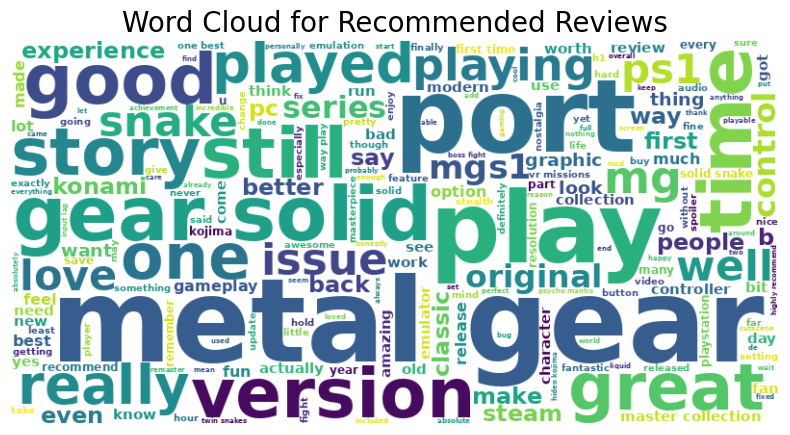

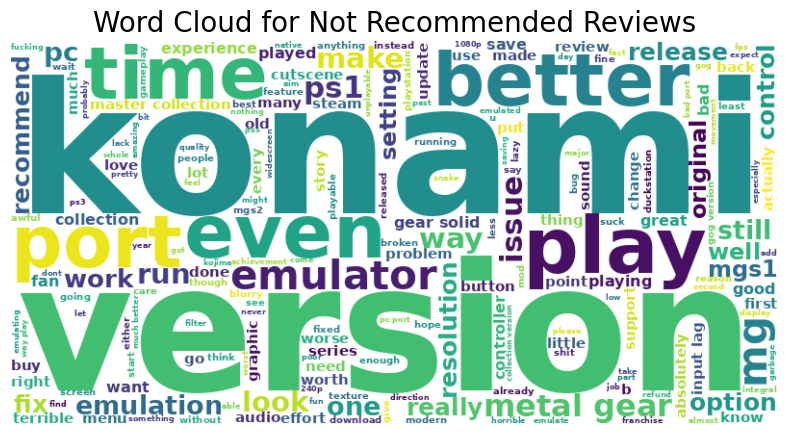

In [34]:
# Path to a TrueType font file (You may need to adjust the path to a TrueType font file on your system)
font_path = '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf'

# Generate word clouds
def generate_wordcloud(text, title, color, font_path):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap='viridis', font_path=font_path).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=20)
    plt.show()

# Word cloud for recommended reviews
generate_wordcloud(recommended_text_cleaned, 'Word Cloud for Recommended Reviews', 'white', font_path)

# Word cloud for not recommended reviews
generate_wordcloud(not_recommended_text_cleaned, 'Word Cloud for Not Recommended Reviews', 'white', font_path)

There are several words that are prominent in both word clouds, but with different contexts. Recommended reviews often include some critiques of the game, while Not Recommended reviews sometimes mention their praise for the game.

In the Recommended word cloud, the frequent mention of "story" and "experience" highlights that users appreciate the narrative and overall gameplay experience. Words like "version" and "port" are frequently mentioned in both word clouds as key points of discussion.<br>
In the Not Recommended word cloud, words like "emulator," "emulation," "version," and "ps1" reflect users' dissatisfaction with this game release, often suggesting players emulate the PS1 version instead. The prominence of "konami" in the Not Recommended reviews is particularly noteworthy (and funny), indicating user frustration directed at the game's developer.

To gain deeper insights, it would be beneficial to divide the word clouds further into those with positive sentiment and those with negative sentiment. This would help to more clearly distinguish between the different types of feedback provided by the users.